#Introduction

More than three years have passed since the first case of infection with a new coronavirus (CoV) (SARS-CoV-2) in Wuhan city (Hubei, China).
In late November 2019, near Huanan market, Wuhan, Hubei province (China) described the first case of pneumonia due to a new CoV, also of the genus beta, which was initially designated 2019-nCoV by researchers in China. On February 11, 2020, it was renamed SARS-CoV-2 and the disease was named COVID-19.
The SARS-CoV-2 pandemic has triggered an unprecedented economic and health crisis. Although the diagnosis is microbiological, imaging techniques play an important role in supporting the diagnosis, grading the severity of the disease, guiding treatment, detecting possible complications and assessing therapeutic response. The involvement is mainly pulmonary. Chest radiography in a conventional or portable room is the first imaging method due to its wide availability and low cost, and the most frequent radiological findings are airspace opacities in the form of consolidations and/or ground glass opacities, typically bilateral, peripheral and predominantly in the lower fields.


In this project we will implement a deep neural network for the classification or diagnosis of patients with suspected COVID-19 virus infection from medical image data (Chest X-Rays), then we will translate it into a web framework called <code> Flask <code>

###Modifying the runtime environment and choosing GPU support
Before we start writing the code, let's modify the Google Colab runtime environment to work with GPU hardware.To do this, we go to the 'Runtime Environment' menu and select the 'Change Runtime Environment Type' option and in the panel that will open next we choose GPU in the 'Hardware Acceleration' dropdown.


Google Drive data:
https://drive.google.com/drive/folders/1SLyCIIRvt9YVigaYt-AXtK5dZiQYd3rs?usp=sharing

###Import Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Import the necessary libraries
We load the Sequential libraries for the configuration of the network formed by 2D convolution and max pooling layers, droptout layers and flatten and dense layers.

In [2]:
# TensorFlow: For model trainining and prediction
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential # Model/class on which we build the layers of the network
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
# Conv2D -> for edge detection and image definition (sharpness)
# Pooling -> reduces data size, image dimensionality
# Dropout -> controls overfitting of the model
# Flatten -> transforms the feature material into a 1D vector
# Dense connects the feature vector to the input data vector, label prediction
from tensorflow.keras.optimizers import Adam
# We will use Adam as optimizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Allows us to perform data augmentation tasks
import numpy as np
import matplotlib.pyplot as plt

#Flask:For web application development.
from flask import Flask, render_template, request, jsonify


In [3]:
import os


# Path to the 'Datos' folder in Google Drive
datos_folder_path = '/content/drive/My Drive/Datos'

# Paths to the 'train' and 'test' folders inside 'Datos'
train_folder_path = os.path.join(datos_folder_path, 'train')
test_folder_path = os.path.join(datos_folder_path, 'test')

# List files in the 'train' folder
files_in_train = os.listdir(train_folder_path)
print("Files in 'train' folder:", files_in_train)

# List files in the 'test' folder
files_in_test = os.listdir(test_folder_path)
print("Files in 'test' folder:", files_in_test)


Files in 'train' folder: ['NORMAL', 'COVID']
Files in 'test' folder: ['NORMAL', 'COVID']


#### Within each set we have two directories with chest X-rays for each set : COVID OR NORMAL

In [4]:

train_covid_path = os.path.join(train_folder_path, 'COVID')
train_normal_path = os.path.join(train_folder_path, 'NORMAL')
test_covid_path = os.path.join(test_folder_path, 'COVID')
test_normal_path = os.path.join(test_folder_path, 'NORMAL')

# Now we have the correct paths to the COVID and NORMAL folders
print("Train COVID folder path:", train_covid_path)
print("Train NORMAL folder path:", train_normal_path)
print("Test COVID folder path:", test_covid_path)
print("Test NORMAL folder path:", test_normal_path)

Train COVID folder path: /content/drive/My Drive/Datos/train/COVID
Train NORMAL folder path: /content/drive/My Drive/Datos/train/NORMAL
Test COVID folder path: /content/drive/My Drive/Datos/test/COVID
Test NORMAL folder path: /content/drive/My Drive/Datos/test/NORMAL


###Now lets take a look to the images

In [5]:
# Training Set
train_covid_names = sorted(os.listdir(train_covid_path))
print("\n First 10 images of Training Set (COVID):", train_covid_names[0:10] )
train_normal_names = sorted(os.listdir(train_normal_path))
print("\n First 10 images of Training Set (NORMAL):", train_normal_names[0:10])


 First 10 images of Training Set (COVID): ['COVID-19 (1).jpeg', 'COVID-19 (1).png', 'COVID-19 (10).jpeg', 'COVID-19 (101).jpg', 'COVID-19 (107).jpg', 'COVID-19 (11).jpeg', 'COVID-19 (11).jpg', 'COVID-19 (12).jpeg', 'COVID-19 (12).jpg', 'COVID-19 (13).jpeg']

 First 10 images of Training Set (NORMAL): ['NORMAL(0).jpg', 'NORMAL(1).jpg', 'NORMAL(100).jpg', 'NORMAL(1000).jpg', 'NORMAL(1002).jpg', 'NORMAL(1005).jpg', 'NORMAL(1006).jpg', 'NORMAL(1007).jpg', 'NORMAL(1008).jpg', 'NORMAL(1009).jpg']


In [6]:
# Test Set
test_covid_names = sorted(os.listdir(test_covid_path))
print("\n First 10 images of Test Set (COVID):", test_covid_names[0:10])
test_normal_names = sorted(os.listdir(test_normal_path))
print("\n First 10 images of Test Set (COVID):", test_normal_names[0:10])


 First 10 images of Test Set (COVID): ['COVID-19 (313).jpg', 'COVID-19 (353).jpg', 'COVID-19 (371).jpg', 'COVID-19 (425).jpg', 'COVID-19 (439).jpg', 'COVID-19 (457).jpg', 'COVID-19 (461).jpg', 'COVID-19 (475).jpg', 'COVID-19 (479).jpg', 'COVID-19 (485).jpg']

 First 10 images of Test Set (COVID): ['NORMAL(10).jpg', 'NORMAL(1001).jpg', 'NORMAL(1003).jpg', 'NORMAL(1004).jpg', 'NORMAL(1011).jpg', 'NORMAL(1012).jpg', 'NORMAL(1015).jpg', 'NORMAL(1017).jpg', 'NORMAL(1020).jpg', 'NORMAL(1022).jpg']


In [7]:
# Lets see the longitude of each
print("Training Set longitude:", len(train_covid_names+train_normal_names))
print("Test Set longitude:", len(test_covid_names+test_normal_names))

Training Set longitude: 1811
Test Set longitude: 484


### Image Display

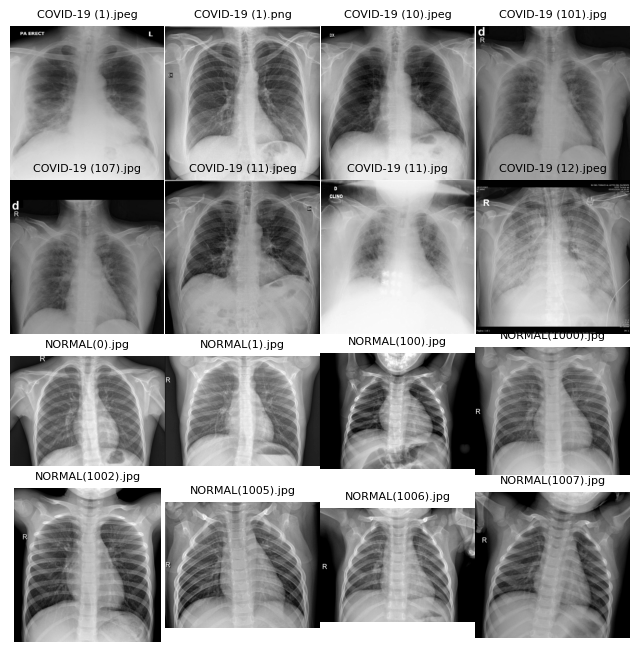

In [8]:
# Let's see some images of the dataset in 4x4 grid
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
covid_images = [os.path.join(train_covid_path, filename) for filename in train_covid_names[:8]]
normal_images = [os.path.join(train_normal_path, filename) for filename in train_normal_names[:8]]

# merged of both lists
merged_images = covid_images + normal_images

# Configuration of the subgraph grid
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(4, 4, wspace=0.0, hspace=0.0)

# Iteration over the images and show them in the grid
for i, image_path in enumerate(merged_images):
    ax = plt.subplot(gs[i])
    image_name = os.path.basename(image_path)
    image_data = mpimg.imread(image_path)
    ax.imshow(image_data, cmap='gray')
    ax.set_title(image_name, fontsize=8)
    ax.axis('off')

plt.show()

### Data Augmentation and Pre-Processing

For data augmentation and preprocessing on medical images, especially in the context of deep learning, you can use <code> TensorFlow's ImageDataGenerator class. <code>

This class provides an efficient way to perform data augmentation and preprocessing while loading images for training neural network models.

In [9]:
# Image Size
# This variable defines the target size for the images. In this case, it's set to (150, 150) pixels,
# meaning that all images will be resized to this dimension.
image_size = (150, 150)
# In this case we need this size because If the image size is too large and you want to reduce it for computational efficiency, you can certainly do that.
# Just keep in mind that reducing the image size may also affect the model's ability to capture fine details.

# Data generator configuration for test and validation with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, # Rescale or Normalize pixel values to [0,1]
    validation_split=0.2, #Splits the data into training and validation sets in this case reserving 20% of the data for validation
    zoom_range=0.2, #Random zoom up to 20%
    horizontal_flip=True #Random Horizontal flip
    )

# Data generator configuration for test and validation (without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)


# Creating of batch generators directly using the specific image paths

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_folder_path, # Path to the directory that contain the training images
    target_size=image_size, # Resize images to the specified size
    subset='training', # Using the subset for training
    batch_size=32, # Number of images in each batch (32 images)
    class_mode='binary' # Binary classification (COVID/NORMAL)
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    train_folder_path,
    target_size=image_size,
    subset='validation', #Using the subset for validation
    batch_size=32,
    class_mode='binary'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_folder_path,
    target_size=image_size,
    batch_size=32,
    class_mode='binary'

)

Found 1449 images belonging to 2 classes.
Found 362 images belonging to 2 classes.
Found 484 images belonging to 2 classes.


In [10]:
# Let's check if everything is our classification is correct
train_generator.class_indices

{'COVID': 0, 'NORMAL': 1}

In [11]:
# Let's check our sample size for the training model
print(f'The size of images is {train_generator.image_shape}')
if train_generator.image_shape[2] == 3:
    print('The dimension Three value indicates that the images are in RGB format,')
    print('where the color of each pixel is a combination of (RED+GREEN+BLUE).')
else:
    print('The images may not be in RGB format.')

The size of images is (150, 150, 3)
The dimension Three value indicates that the images are in RGB format,
where the color of each pixel is a combination of (RED+GREEN+BLUE).


## Let's build the Convulutional Neural Network (CNN)

 At this point we can define our convolutional NR model that will learn from the grouped data we have worked on previously.
 We will build the model by adding layers to an instance of the Sequential class

###Sequential

is a linear stack of layers in Keras, where you can simply add one layer at a time. It's a straightforward and common choice for most standard neural network architectures, especially when the information flows sequentially from the input layer through the hidden layers to the output layer. This simplicity makes it suitable for a wide range of tasks.

In [12]:
# Define the CNN model
model = Sequential()

In the first layer that we will use to extract image characteristics is a convolution layer that applies filters made up of small squares that # map the input image, map the input image. We will select 32 features to extract

In [13]:
# Step 1: Convolutional layer
# Conv2D: Number of filters, filter size, input shape, and activation function
# 32 filters, each with a size of 3x3, input shape the same that we have for RGB images
# ReLU activation
model.add(Conv2D(32, (3,3), input_shape=(150, 150, 3), activation='relu'))

# Step 2: Second Poolin Layer
# Maxpoolin with a 2x2 pool size
model.add(MaxPooling2D(pool_size=(2,2)))

# Step 3: Second Convolutional layer
# 64 filters, each with a size of 3x3, and ReLU activation
model.add(Conv2D(64, (3,3), activation='relu'))

# Step 4: Second Pooling Layer
model.add(MaxPooling2D(pool_size=(2,2)))

# Step 5: Flattening
# Flatten the output, No parameters, it flattens the input
model.add(Flatten())

# Step 6:Fully Connected Layer
# Fully connected layer with 128 neurons otherwise Adding more neurons, can potentially lead to overfitting,
# especially if the model becomes too complex relative to the size of your dataset
# Dense: Number of neurons and activation function
model.add(Dense(128, activation='relu'))

# Step 7: Dropout
# Dropout layer with a dropout rate to reduce overfitting
model.add(Dropout(0.5))

# Step 8: Output Layer
# Output layer with 1 neuron for binary classification
# Sigmoid activation
model.add(Dense(1, activation='sigmoid'))

# Final Step: Compile and Train the Model
# Adam optimizer, ninary crossentropy loss for binary classification and accuracy as the metric
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

### Explanation:
- Optimizer (Adam):

   The optimizer is responsible for updating the weights of the neural network during training. Adam is a popular optimization algorithm that adapts the learning rates of individual parameters based on their past gradients. It combines the advantages of two other methods: RMSprop and Momentum.

- Learning Rate (lr=0.001):

  The learning rate is a hyperparameter that determines the step size at each iteration while moving toward a minimum of a loss function. A small learning rate allows for more precise updates, but it can slow down the learning process. A larger learning rate speeds up learning but may cause the model to overshoot the minimum.

- Loss ('binary_crossentropy'):

  The loss function is a measure of how well the model is performing. For binary classification problems (where you have two classes like COVID and NORMAL), 'binary_crossentropy' is a suitable choice. This loss function is particularly designed for binary classification tasks.

- Metrics (['accuracy']):

  Metrics are used to evaluate the performance of the model during training. 'accuracy' is a common metric for classification problems. It represents the proportion of correctly classified samples out of the total number of samples.

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 128)               1

Epoch 1/10
46/46 [==============================] - 68s 1s/step - loss: 0.3934 - accuracy: 0.8496 - val_loss: 0.1360 - val_accuracy: 0.9586
Epoch 2/10
46/46 [==============================] - 51s 1s/step - loss: 0.1389 - accuracy: 0.9531 - val_loss: 0.1229 - val_accuracy: 0.9530
Epoch 3/10
46/46 [==============================] - 52s 1s/step - loss: 0.1132 - accuracy: 0.9586 - val_loss: 0.0906 - val_accuracy: 0.9724
Epoch 4/10
46/46 [==============================] - 52s 1s/step - loss: 0.0975 - accuracy: 0.9641 - val_loss: 0.0920 - val_accuracy: 0.9696
Epoch 5/10
46/46 [==============================] - 52s 1s/step - loss: 0.0980 - accuracy: 0.9614 - val_loss: 0.0888 - val_accuracy: 0.9751
Epoch 6/10
46/46 [==============================] - 55s 1s/step - loss: 0.1308 - accuracy: 0.9545 - val_loss: 0.0848 - val_accuracy: 0.9751
Epoch 7/10
46/46 [==============================] - 52s 1s/step - loss: 0.0813 - accuracy: 0.9731 - val_loss: 0.0986 - val_accuracy: 0.9751
Epoch 8/10
46/46 [==

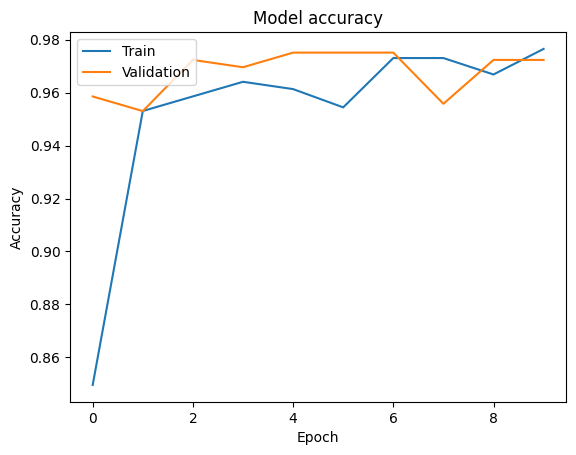

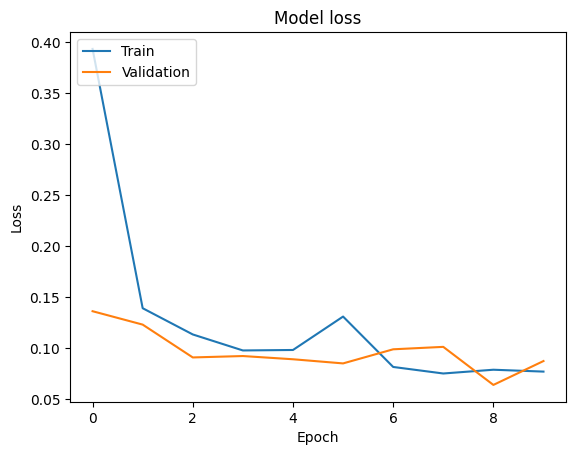

In [15]:
# Train the model
# The history object records the progress during training,
# collects the value of the loss function and the evaluation metric at each step of the training process
# and the evaluation metric at each step of the process
history = model.fit(
    train_generator,
    epochs=10,  # Adjust the number of epochs based on our experimentation
    validation_data=val_generator
)

# Plot the training history
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
# To evaluate the performance of the model we plot the values of the metrics of interest as a function of the
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


### We validate the model on the evaluation sample.
Let's train the dataset that we already have

In [16]:
test_loss, test_accuracy = model.evaluate(test_generator)
y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype(int)

16/16 [==============================] - 11s 638ms/step


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print('Results on test set')
print(" - Loss: {:.2f}, Accuracy: {:.2f} ".format(test_loss, test_accuracy))


Precision: 0.6606060606060606
Recall: 0.6876971608832808
F1-score: 0.6738794435857806
Results on test set
 - Loss: 0.10, Accuracy: 0.96 


###Results (predictions) on unseen data



In [18]:
# En esta última acción evaluaremos nuestro modelo sobre todo el conjunto de imágenes de radiografías torácicas
# para obtener un resultado (predicción) para el paciente: infección COVID o sano
from google.colab import files
from keras.preprocessing import image
from PIL import Image
uploads = files.upload()
for filename in uploads.keys():
  img_path = '/content/' + filename
  img = image.load_img(img_path, target_size=(150, 150))
  data = image.img_to_array(img)
  data = np.expand_dims(data, axis=0)
  prediction = model.predict(data)
  print("\nX-ray Image:", filename)

  if prediction == 0:
    print(" => COVID-19 Detected")
  else:
    print(" => Normal Status")




Saving NORMAL(22).jpg to NORMAL(22).jpg
1/1 [==============================] - 0s 131ms/step

X-ray Image: NORMAL(22).jpg
 => Normal Status


### Saving the Model

In [19]:
# Saving the model in the native Keras format
model.save('my_model.keras')